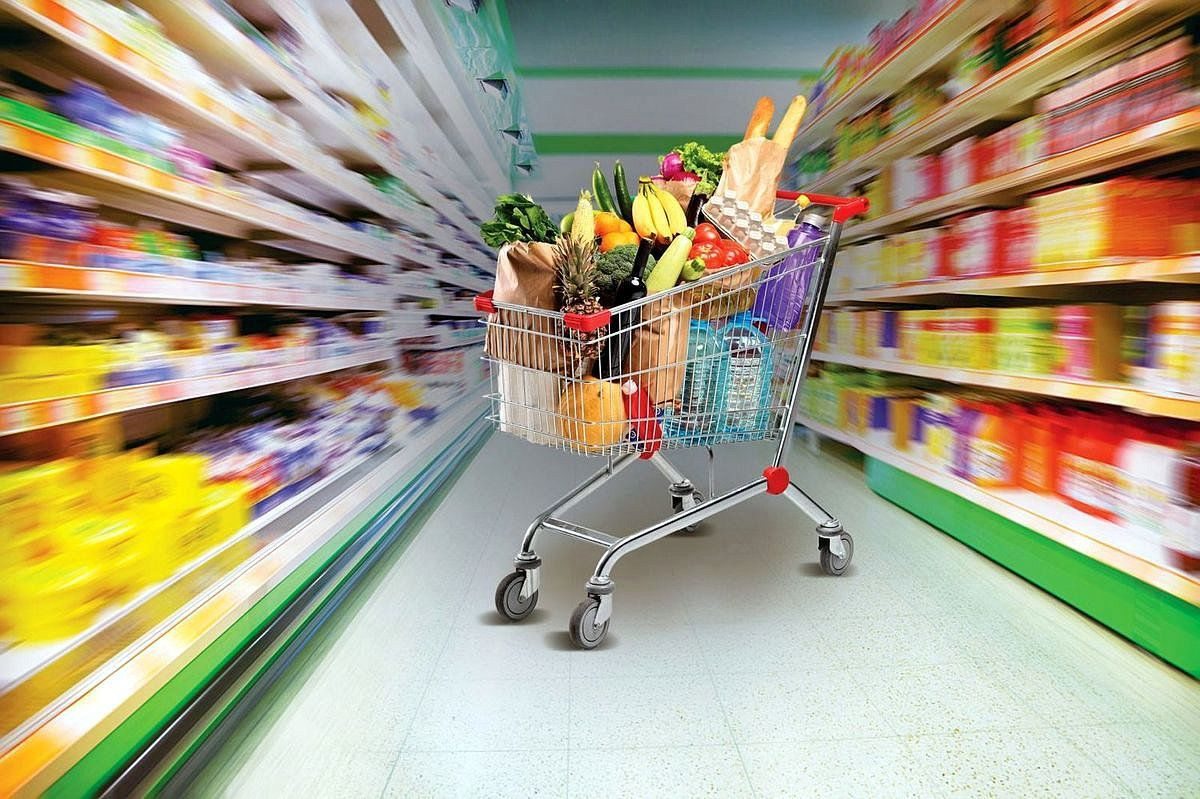

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Introduction
A time series is a sequence of values describing a process taking place over time, measured at successive points in time, usually at regular intervals. Thus, the data are ordered relative to non-random moments of time, and, therefore, unlike random samples, they may contain additional information that you can try to extract.

At work, many data scientists in different countries almost daily face various tasks related to time series. Therefore, I consider for myself the skill of working with time series as very important.

This kernel is my first attempt to create a time series solution in the "Store Sales - Time Series Forecasting" competition. The goal of this competition is to build a model that more accurately products sales in units for thousands of products sold in different Favorita stores. Please consider upvoting if this is useful to you.

#Table of contents:

1.Import of Required Modules

2.Import & config of Data

3.Machine Learning Models

4.Creating Submission File

5.Conclusion

#1.Import of Required Modules

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
from matplotlib.colors import ListedColormap
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from pandas import date_range
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import warnings

from joblib import Parallel, delayed

# switch off the warnings
warnings.filterwarnings("ignore")

#2.Import & config of Data

In [ ]:
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv', header = 0)
df_trans = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', header = 0)

#### Calendar

In [ ]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

#### Oil

In [ ]:
df_oil.head()

In [ ]:
df_stores.head()

In [ ]:
df_trans.head()

In [ ]:
df_oil['ma_oil'] = df_oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.merge(df_oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill', inplace=True)

#### Day of week

In [ ]:
calendar['dofw'] = calendar.index.dayofweek

#### Holidays

In [ ]:
df_holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)

df_holidays['date'] = df_holidays['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction
df_holidays = df_holidays.set_index('date').sort_index()

df_holidays = df_holidays[df_holidays.locale == 'National'] # National level only for simplicity

df_holidays = df_holidays.groupby(df_holidays.index).first() # Keep one event only

#### Work days

In [ ]:
calendar['wd'] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False
calendar = calendar.merge(df_holidays, how='left', left_index=True, right_index=True)
calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

In [ ]:
calendar.plot(figsize=(20,10), title= "Oil", xlabel= "date", rot=90);

In [ ]:
df_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

In [ ]:
df_train.head()

In [ ]:
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)

df_test.date = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [ ]:
df_test.head()

In [ ]:
sdate = '2017-04-01'
edate = '2017-08-15'

In [ ]:
y = df_train.unstack(['store_nbr', 'family']).loc[sdate:edate]
fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
X = dp.in_sample()

In [ ]:
# Extentions
X['oil']  = calendar.loc[sdate:edate]['ma_oil'].values
X['dofw'] = calendar.loc[sdate:edate]['dofw'].values
X['wd']   = calendar.loc[sdate:edate]['wd'].values
X['type'] = calendar.loc[sdate:edate]['type'].values

X = pd.get_dummies(X, columns=['dofw'], drop_first=True)
X = pd.get_dummies(X, columns=['type'], drop_first=False)

In [ ]:
X.head()

#3.Machine Learning Models

#### Ridge

In [ ]:
model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [ ]:
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0

y_target.groupby('family').apply(lambda x: mean_squared_log_error(x['sales'], x['sales_pred']))

In [ ]:
df_train.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

#### RandomForest

In [ ]:
class SalesRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            
            model = RandomForestRegressor(n_estimators = 300, n_jobs=-1, random_state=1)
            
        else:
            
            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
            
        model.fit(X, y)

        return model

    def fit(self, X, y):

        self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                              verbose=self.verbose,
                              )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        
        return
    
    def predict(self, X):
        
        y_pred = Parallel(n_jobs=self.n_jobs, 
                          verbose=self.verbose)(delayed(e.predict)(X) for e in self.estimators_)
        
        return np.stack(y_pred, axis=1)

In [ ]:
model = SalesRegressor(n_jobs=-1, verbose=0)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [ ]:
# We get a prediction
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0
y_target.groupby('family').apply(lambda x: mean_squared_log_error(x['sales'], x['sales_pred']))

#### Date selection

In [ ]:
stest = '2017-08-16'
etest = '2017-08-31'
X_test = dp.out_of_sample(steps=16)

In [ ]:
# Extentions
X_test['oil']  = calendar.loc[stest:etest]['ma_oil'].values
X_test['dofw'] = calendar.loc[stest:etest]['dofw'].values
X_test['wd']   = calendar.loc[stest:etest]['wd'].values
X_test = pd.get_dummies(X_test, columns=['dofw'], drop_first=True)

# No national level events in this period
X_test[['type_Additional', 'type_Event', 'type_Holiday', 'type_Transfer']] = 0
sales_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_pred = sales_pred.stack(['store_nbr', 'family'])
sales_pred[sales_pred < 0] = 0. # Sales should be >= 0

#4.Creating Submission File

In [ ]:
df_sub = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv', index_col='id')
df_sub.sales = sales_pred.values
df_sub.to_csv('./submission.csv')

#5. Conclusion
Thank you for reading my new notebook!

Hope, you liked it and it was interesting for you! There are some more my notebooks:

https://www.kaggle.com/code/igorprikhodko/1-1-supervised-learning-classification-knn-titanic

https://www.kaggle.com/code/igorprikhodko/1-2-supervised-learning-classification-titanic

https://www.kaggle.com/code/igorprikhodko/1-3-supervised-learning-regression-house-prices

https://www.kaggle.com/code/igorprikhodko/classification-cnn-digit-recognizer

I would be grateful for any feedback!